In [1]:
import duckdb
import pandas as pd
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%reload_ext sql
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:default:

There's a new jupysql version available (0.7.9), you're running 0.7.8. To upgrade: pip install jupysql --upgrade
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [47]:
import matplotlib.pyplot as plt 

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    LIMIT 5
'''

result = con.execute(query2)
data = result.fetchdf()
pd.set_option('display.max_columns', 54)
print(data)

   season_id  team_id_home team_abbreviation_home           team_name_home  \
0      21946    1610610035                    HUS          Toronto Huskies   
1      21946    1610610034                    BOM        St. Louis Bombers   
2      21946    1610610032                    PRO  Providence Steamrollers   
3      21946    1610610025                    CHS            Chicago Stags   
4      21946    1610610028                    DEF          Detroit Falcons   

      game_id  game_date matchup_home wl_home  min  fgm_home  fga_home  \
0  0024600001 1946-11-01  HUS vs. NYK       L    0      25.0       NaN   
1  0024600003 1946-11-02  BOM vs. PIT       W    0      20.0      59.0   
2  0024600002 1946-11-02  PRO vs. BOS       W    0      21.0       NaN   
3  0024600004 1946-11-02  CHS vs. NYK       W    0      21.0       NaN   
4  0024600005 1946-11-02  DEF vs. WAS       L    0      10.0       NaN   

   fg_pct_home  fg3m_home  fg3a_home  fg3_pct_home  ftm_home  fta_home  \
0          N

%sql top_schools << SELECT school, count(*) as count FROM read_csv_auto('../dataset/csv/common_player_info.csv') AS common_player_info GROUP BY school ORDER BY count DESC LIMIT 40;
top_schools

In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
import duckdb 

#cnx = sqlite3.connect(r'C:\Users\Yoric\Uni\dataviz-2023\dataset\nba.sqlite')
# Connect to DuckDB and specify the folder path containing CSV files
con = duckdb.connect(database=':memory:', read_only=False)
# Register the CSV files as DuckDB tables
#con.execute("CREATE EXTERNAL TABLE Game USING csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')")

query = '''
    SELECT 
        SEASON_ID AS season,
        COUNT(DISTINCT GAME_ID) AS total_game_count,
        SUM(CASE WL_HOME 
                WHEN'W' THEN 1
                ELSE 0
            END) AS home_win_count
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON
    ORDER BY SEASON
'''

#df_summary = pd.read_sql_query(query2, cnx)
#%sql df_summary << SELECT SEASON_ID AS season, COUNT(DISTINCT GAME_ID) AS total_game_count, SUM(CASE WL_HOME WHEN'W' THEN 1 ELSE 0 END) AS home_win_count FROM read_csv_auto('../dataset/csv/game.csv') GROUP BY SEASON ORDER BY SEASON;
result = con.execute(query)
df_summary = result.fetchdf()
df_summary['home_win_percentage'] = round(100*df_summary['home_win_count'] / df_summary['total_game_count'], 2)
df_summary['season'] = df_summary['season'].astype(str).str[1:]

df_summary
px.line(df_summary, y="home_win_percentage", x="season", title="Overall win percentage from 1946-2022")

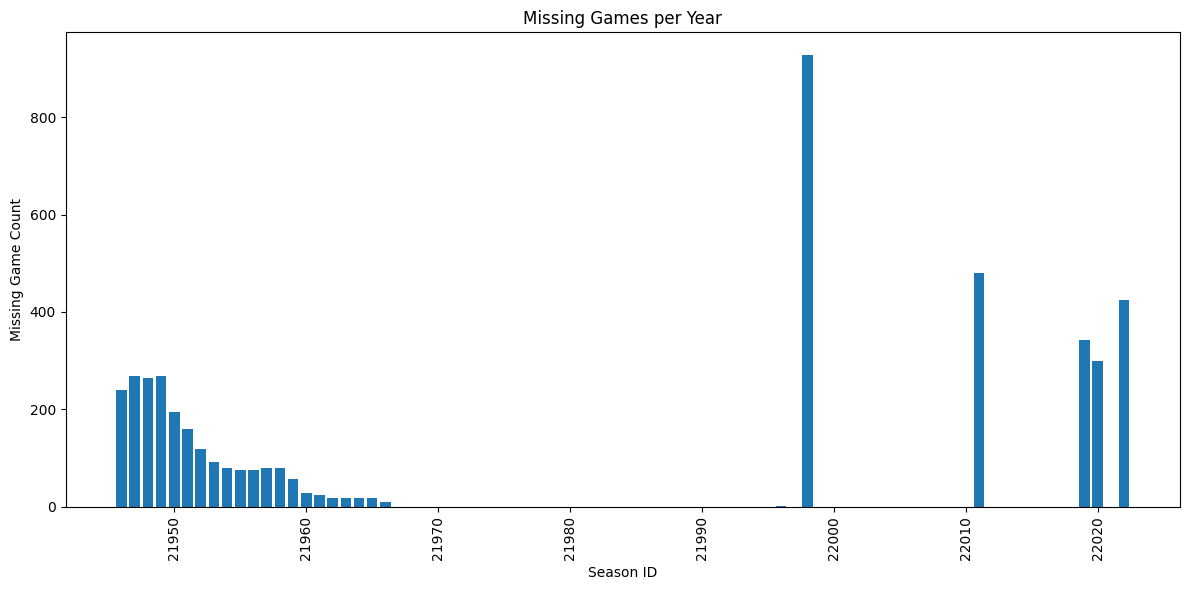

In [25]:
import matplotlib.pyplot as plt 

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Get unique team IDs
unique_team_ids = set(data['team_id_home'].unique()).union(set(data['team_id_away'].unique()))

# Define the expected number of games in a season (adjust according to your data)
expected_games_per_season = 82

# Create dictionaries to store missing game counts per team and year
missing_games_per_team = {}
missing_games_per_year = {}

# Iterate over each team ID
for team_id in unique_team_ids:
    # Retrieve unique season IDs for the specified team (both home and away games)
    team_season_ids_home = data.loc[data['team_id_home'] == team_id, 'season_id'].unique()
    team_season_ids_away = data.loc[data['team_id_away'] == team_id, 'season_id'].unique()
    team_season_ids = set(team_season_ids_home).union(set(team_season_ids_away))

    # Iterate through each season ID for the specified team
    for season_id in team_season_ids:
        # Retrieve unique game IDs for the current team and season (both home and away games)
        team_season_games_home = data.loc[(data['team_id_home'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games_away = data.loc[(data['team_id_away'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games = set(team_season_games_home).union(set(team_season_games_away))

        # Check if the count of unique game IDs is less than the expected number of games
        if len(team_season_games) < expected_games_per_season:
            missing_games = expected_games_per_season - len(team_season_games)

            # Update missing game count per team
            if team_id in missing_games_per_team:
                missing_games_per_team[team_id] += missing_games
            else:
                missing_games_per_team[team_id] = missing_games

            # Update missing game count per year
            if season_id in missing_games_per_year:
                missing_games_per_year[season_id] += missing_games
            else:
                missing_games_per_year[season_id] = missing_games

# Create lists for season IDs and missing game counts
season_ids = list(missing_games_per_year.keys())
missing_game_counts_per_year = list(missing_games_per_year.values())

# Plot the amount of missing games per year
plt.figure(figsize=(12, 6))
plt.bar(season_ids, missing_game_counts_per_year)
plt.xlabel('Season ID')
plt.ylabel('Missing Game Count')
plt.title('Missing Games per Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

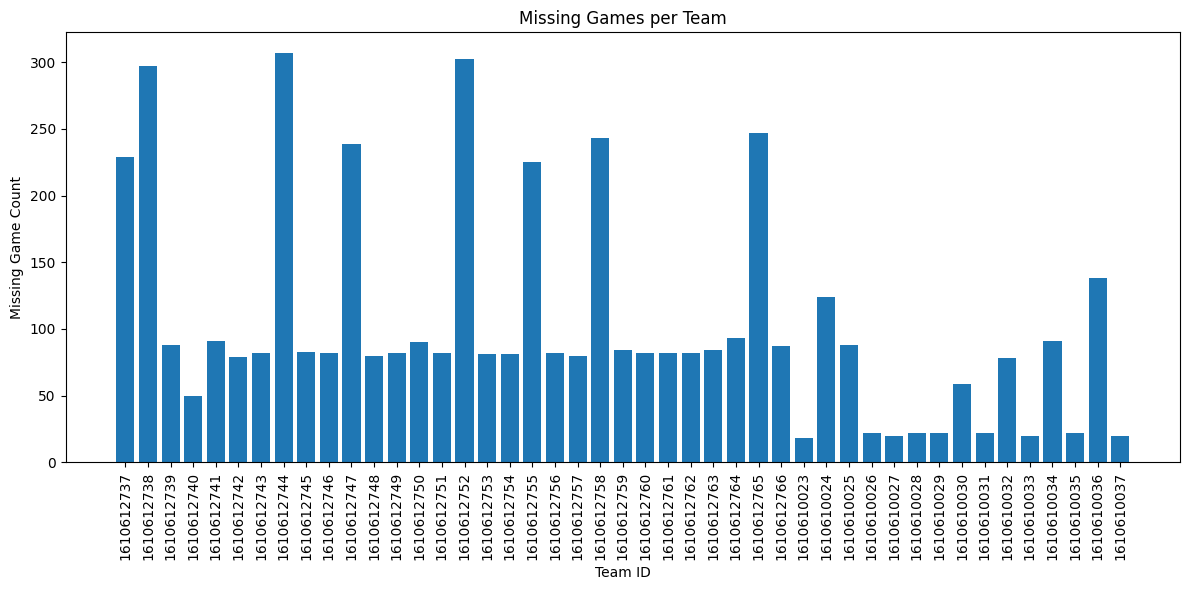

In [49]:
import matplotlib.pyplot as plt

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Get unique team IDs
unique_team_ids = set(data['team_id_home'].unique()).union(set(data['team_id_away'].unique()))

# Define the expected number of games in a season (adjust according to your data)
expected_games_per_season = 82

# Create dictionaries to store missing game counts per team and year
missing_games_per_team = {}
missing_games_per_year = {}

# Iterate over each team ID
for team_id in unique_team_ids:
    # Retrieve unique season IDs for the specified team (both home and away games)
    team_season_ids_home = data.loc[data['team_id_home'] == team_id, 'season_id'].unique()
    team_season_ids_away = data.loc[data['team_id_away'] == team_id, 'season_id'].unique()
    team_season_ids = set(team_season_ids_home).union(set(team_season_ids_away))

    # Iterate through each season ID for the specified team
    for season_id in team_season_ids:
        # Retrieve unique game IDs for the current team and season (both home and away games)
        team_season_games_home = data.loc[(data['team_id_home'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games_away = data.loc[(data['team_id_away'] == team_id) & (data['season_id'] == season_id), 'game_id'].unique()
        team_season_games = set(team_season_games_home).union(set(team_season_games_away))

        # Check if the count of unique game IDs is less than the expected number of games
        if len(team_season_games) < expected_games_per_season:
            missing_games = expected_games_per_season - len(team_season_games)

            # Update missing game count per team
            if team_id in missing_games_per_team:
                missing_games_per_team[team_id] += missing_games
            else:
                missing_games_per_team[team_id] = missing_games

            # Update missing game count per year
            if season_id in missing_games_per_year:
                missing_games_per_year[season_id] += missing_games
            else:
                missing_games_per_year[season_id] = missing_games

# Create lists for team IDs and missing game counts
team_ids = list(missing_games_per_team.keys())
missing_game_counts = list(missing_games_per_team.values())

plt.figure(figsize=(12, 6))
plt.bar(range(len(team_ids)), missing_game_counts)
plt.xlabel('Team ID')
plt.ylabel('Missing Game Count')
plt.title('Missing Games per Team')
plt.xticks(range(len(team_ids)), team_ids, rotation=90)
plt.tight_layout()
plt.show()

#Probably all the oldest team have more "missing" games because in the beginnign in 1940s there were no fixed amount of games

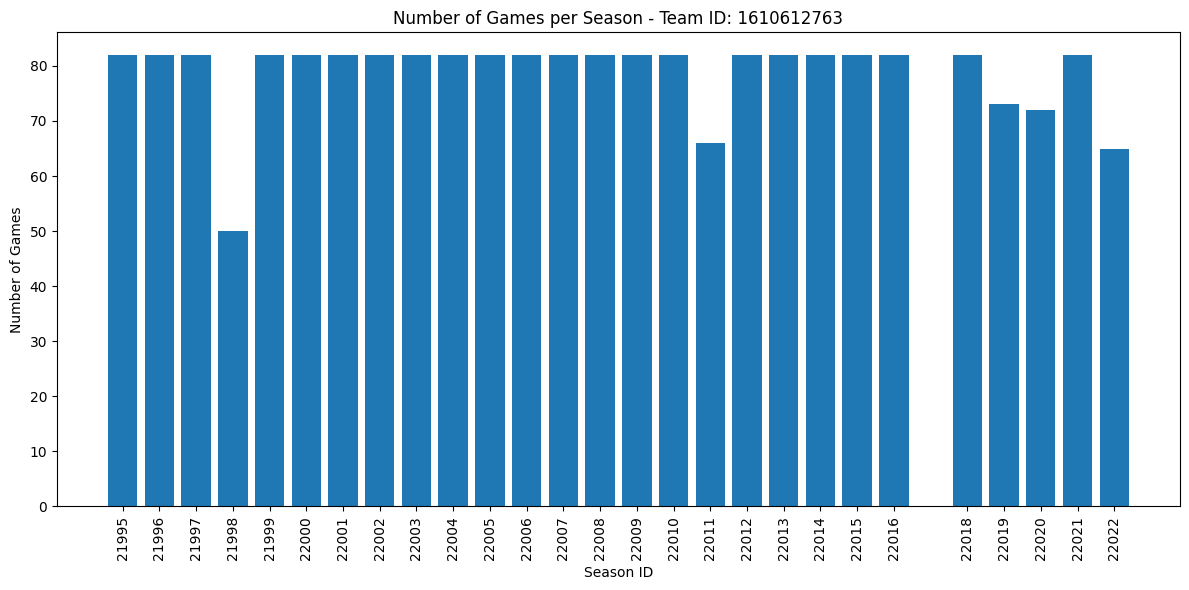

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

query2 = '''
    SELECT 
    *
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
'''

result = con.execute(query2)
data = result.fetchdf()

# Define the team ID for which you want to plot the games
team_id = 1610612763  # Replace with the desired team ID

# Filter the data for the specified team
team_data = data[(data['team_id_home'] == team_id) | (data['team_id_away'] == team_id)]

# Get unique season IDs for the specified team
team_season_ids = team_data['season_id'].unique()

# Count the number of games played by the team in each season
games_per_season = team_data['season_id'].value_counts()

# Create a bar plot for the games per season
plt.figure(figsize=(12, 6))
plt.bar(games_per_season.index, games_per_season.values)
plt.xlabel('Season ID')
plt.ylabel('Number of Games')
plt.title(f'Number of Games per Season - Team ID: {team_id}')
plt.xticks(team_season_ids, rotation=90)
plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
    SELECT
    team_name_home,
    team_name_away,
    plus_minus_away,
    game_date
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    WHERE game_date='2003-04-16'
'''
    
result = con.execute(query2)
data = result.fetchdf()

print(data)


           team_name_home          team_name_away  plus_minus_away  game_date
0          Boston Celtics         Detroit Pistons               -7 2003-04-16
1     Cleveland Cavaliers         Toronto Raptors              -10 2003-04-16
2     New Orleans Hornets           Atlanta Hawks              -15 2003-04-16
3     Seattle SuperSonics            Phoenix Suns              -14 2003-04-16
4          Denver Nuggets         Houston Rockets                5 2003-04-16
5       Memphis Grizzlies  Minnesota Timberwolves                8 2003-04-16
6       San Antonio Spurs        Dallas Mavericks               21 2003-04-16
7        Sacramento Kings               Utah Jazz              -11 2003-04-16
8          Indiana Pacers         New Jersey Nets               -7 2003-04-16
9      Philadelphia 76ers      Washington Wizards              -20 2003-04-16
10   Los Angeles Clippers  Portland Trail Blazers              -14 2003-04-16
11  Golden State Warriors      Los Angeles Lakers               

C:\Users\Yoric\AppData\Local\Temp\ipykernel_20112\4273947542.py:44: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



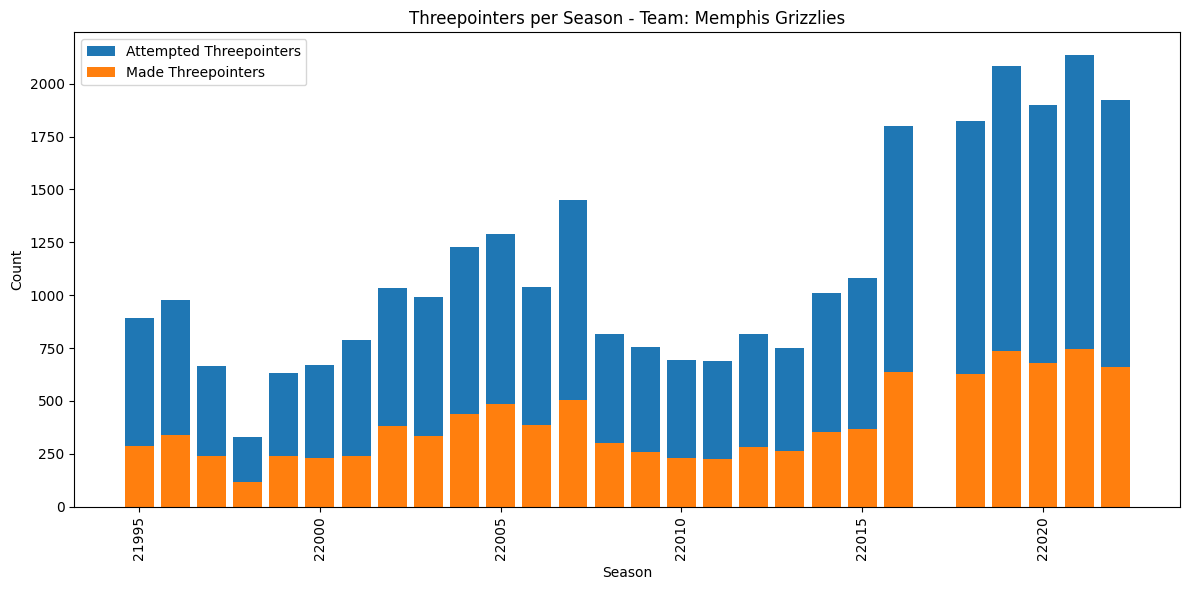

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import random

con = duckdb.connect(database=':memory:', read_only=False)
# Load your table into a DataFrame (assuming it's named 'data')
query2 = '''
   SELECT 
        SEASON_IDcd AS season,
        TEAM_ID_HOME AS team_id,
        TEAM_NAME_HOME AS team_name,
        FG3m_HOME AS made_threepointers,
        FG3a_HOME AS attempted_threepointers,
        FG3_PCT_HOME AS three_point_percentage,
        COUNT(TEAM_ID_HOME) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_HOME, TEAM_NAME_HOME, FG3_PCT_HOME, FG3m_HOME, FG3a_HOME
    
    UNION
    
    SELECT 
        SEASON_ID AS season,
        TEAM_ID_AWAY AS team_id,
        TEAM_NAME_AWAY AS team_name,        
        FG3m_AWAY AS made_threepointers,
        FG3a_AWAY AS attempted_threepointers,
        FG3_PCT_AWAY AS three_point_percentage,
        COUNT(TEAM_ID_AWAY) AS team_game_count,
    FROM read_csv_auto('C:/Users/Yoric/Uni/dataviz-2023/dataset/csv/game.csv')
    GROUP BY SEASON_ID, TEAM_ID_AWAY, TEAM_NAME_AWAY, FG3_PCT_AWAY, FG3m_AWAY, FG3a_AWAY
'''
    
result = con.execute(query2)
data = result.fetchdf()

team_ids = list(set(data['team_id']))
# Select one random team ID
random_team_id = random.choice(team_ids)

# Filter the DataFrame for the selected team
random_team = data[data['team_id'] == random_team_id]

# Group by season and sum the made and attempted threepointers
grouped_df = random_team.groupby('season').sum()

# Plot stacked bar plot for made and attempted threepointers per season
plt.figure(figsize=(12, 6))
plt.bar(grouped_df.index, grouped_df['attempted_threepointers'], label='Attempted Threepointers')
plt.bar(grouped_df.index, grouped_df['made_threepointers'], label='Made Threepointers')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Threepointers per Season - Team: {}'.format(random_team['team_name'].values[0]))
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [107]:
print(grouped_df)

           team_id  made_threepointers  attempted_threepointers
season                                                         
1945    8053063759                 0.0                      0.0
1946    8053063759                 7.0                     17.0
1947    8053063759                 0.0                      0.0
1948    8053063759                 0.0                      0.0
1949    8053063759                 0.0                      0.0
...            ...                 ...                      ...
2019    8053063759                 0.0                      0.0
2020    8053063759                 0.0                      0.0
2021    8053063759                 0.0                      0.0
2022    8053063759                 0.0                      0.0
2023    8053063759                 0.0                      0.0

[79 rows x 3 columns]


Findings:
    
    Missing two total seasons 1988 and 2017 

    only the games since the last team relocation are stored e. g. Golden State Warriors
        --> TeamID in the query solves this 
    investigate seasons 1998 further
    
    timely investigation reasonable since 1966 beforehand the were no fixed amount of games per team and year
    
    Season games are only in the table check it for another season then 02/03
    